# Title: Not so Trashy Text Summarizer
by Federico Rubino, Michael Haidar and Frank Piva

The goal of our project is to create a Natural Language Processing (NLP) model for abstractive document summarization. 
Text summarization, creating concise and understandable summaries containing key information and general meaning, is broadly done in one of two approaches: extractive and abstractive summarization. Extractive summarization produces the most important text, verbatim, from the original document. Abstractive summarization generates new text from the original document (Allahyari, 2017). To produce such a system we will use a variant of Recurrent Neural Networks(RNN). The stretch goal is to generalize our system to summarize legal or medical documents. 

In [ ]:
# environment intialization

from bs4 import BeautifulSoup
from IPython.display import display, Markdown, Latex
from keras.preprocessing.text import Tokenizer 
from keras.preprocessing.sequence import pad_sequences
from nltk.corpus import stopwords
from nltk.tokenize import sent_tokenize
from nltk.translate.bleu_score import sentence_bleu
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, Concatenate, TimeDistributed, Layer
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping

import nltk
import numpy as np
import pandas as pd 
import re
import tensorflow as tf
import warnings

nltk.download('punkt') # one time execution
pd.set_option("display.max_colwidth", 200)
warnings.filterwarnings("ignore")

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


# Problem Statement
In this notebook, we will build an abstractive based text summarizer using deep learning using keras

We had a lot of influence from the following [article.](https://www.analyticsvidhya.com/blog/2019/06/comprehensive-guide-text-summarization-using-deep-learning-python/)

We set up 6 inintial objectives to solve the issue of creating a neural net that could analyse a text and create a summary from it. The goal was to be able to feed it any text no matter the context and be able to create a summary or an abstract out of it. Overall this was intended to make us a lot more familiar with how abstract layers work, how to properly use tokenizers, and develop an intuition for RNNs.

## Baseline Objectives/Phases:  
- Phase 1:
Understand the problem space
Summarize possible RNNs to use
Explore data ([trashy] Daily Mail)
- Phase 2:
Using the Amazon reviews to create a working model
Code working RNN model
Code text generator
Generate some text for one article 
- Phase 3:
Develop better understanding of our problem space
Produce abstractive summaries
- Phase 4:
Test model with covid19sum dataset
Fine Tuning
- Phase 5:
Find legal document dataset
preprocess documents
- Phase 6: 
Legal document summaries.


# Custom Attention Layer

We had a lot of influence from the following [article](https://www.analyticsvidhya.com/blog/2019/06/comprehensive-guide-text-summarization-using-deep-learning-python/) for creating this Attention layer.

Introduced by Bahdanau et al., attention is a popular approach to focus resources on a specific set of most relevant elements. For instance, the background of an image may be of little importance when asking about the subject, but more important if asking about the setting. Rather than tailoring preprocessing or feature engeneering, computing the relevance of elements is weighed by the neural architecture (Galassi, et al. 2019).

For NLP, attention is applied to either global or local source positions(ie: to a few paragraphs , sentence by sentence, or word by word) For abstractive text summarization of scientific articles global attention may be best applied to the entirety of the paper. 

How the attention layer works with the encoder and decoder:
  - every time step the encoder ouputs the hidden state
  - every time step the decoder outputs the hidden state
  - an alignment score is calculated when comparing target and source word. pass the alignment scores through a softmax to get the attention weights
      - softmax makes big numbers very big and negative numbers very small positive numbers. (e^x) the higher it predicts one value the lower it predicts others, this is sometimes refered to as attentuation, hence the name.
  - We can use these weights to calculate "context" by doing a linear sum of products with the hidden states from the encoder
  - concatenate the hidden states from the decoder with the context
  - pass these through a dense layer to produce the output of the decoder which is then used for the proability of the next word


In [ ]:
class AttentionLayer(Layer):
    """
    This class implements Bahdanau attention (https://arxiv.org/pdf/1409.0473.pdf).
    There are three sets of weights introduced W_a, U_a, and V_a
     """

    def __init__(self, **kwargs):
        super(AttentionLayer, self).__init__(**kwargs)

    def build(self, input_shape):
        assert isinstance(input_shape, list)
        # Create a trainable weight variable for this layer.

        self.W_a = self.add_weight(name='W_a',
                                   shape=tf.TensorShape((input_shape[0][2], input_shape[0][2])),
                                   initializer='uniform',
                                   trainable=True)
        self.U_a = self.add_weight(name='U_a',
                                   shape=tf.TensorShape((input_shape[1][2], input_shape[0][2])),
                                   initializer='uniform',
                                   trainable=True)
        self.V_a = self.add_weight(name='V_a',
                                   shape=tf.TensorShape((input_shape[0][2], 1)),
                                   initializer='uniform',
                                   trainable=True)

        super(AttentionLayer, self).build(input_shape)  # Be sure to call this at the end

    def call(self, inputs, verbose=False):
        """
        inputs: [encoder_output_sequence, decoder_output_sequence]
        """
        assert type(inputs) == list
        encoder_out_seq, decoder_out_seq = inputs
        if verbose:
            print('encoder_out_seq>', encoder_out_seq.shape)
            print('decoder_out_seq>', decoder_out_seq.shape)

        def energy_step(inputs, states):
            """ Step function for computing energy for a single decoder state
            inputs: (batchsize * 1 * de_in_dim)
            states: (batchsize * 1 * de_latent_dim)
            """

            assert_msg = "States must be an iterable. Got {} of type {}".format(states, type(states))
            assert isinstance(states, list) or isinstance(states, tuple), assert_msg

            """ Some parameters required for shaping tensors"""
            en_seq_len, en_hidden = encoder_out_seq.shape[1], encoder_out_seq.shape[2]
            de_hidden = inputs.shape[-1]

            """ Computing S.Wa where S=[s0, s1, ..., si]"""
            # <= batch size * en_seq_len * latent_dim
            W_a_dot_s = K.dot(encoder_out_seq, self.W_a)

            """ Computing hj.Ua """
            U_a_dot_h = K.expand_dims(K.dot(inputs, self.U_a), 1)  # <= batch_size, 1, latent_dim
            if verbose:
                print('Ua.h>', U_a_dot_h.shape)

            """ tanh(S.Wa + hj.Ua) """
            # <= batch_size*en_seq_len, latent_dim
            Ws_plus_Uh = K.tanh(W_a_dot_s + U_a_dot_h)
            if verbose:
                print('Ws+Uh>', Ws_plus_Uh.shape)

            """ softmax(va.tanh(S.Wa + hj.Ua)) """
            # <= batch_size, en_seq_len
            e_i = K.squeeze(K.dot(Ws_plus_Uh, self.V_a), axis=-1)
            # <= batch_size, en_seq_len
            e_i = K.softmax(e_i)

            if verbose:
                print('ei>', e_i.shape)

            return e_i, [e_i]

        def context_step(inputs, states):
            """ Step function for computing ci using ei """

            assert_msg = "States must be an iterable. Got {} of type {}".format(states, type(states))
            assert isinstance(states, list) or isinstance(states, tuple), assert_msg

            # <= batch_size, hidden_size
            c_i = K.sum(encoder_out_seq * K.expand_dims(inputs, -1), axis=1)
            if verbose:
                print('ci>', c_i.shape)
            return c_i, [c_i]

        fake_state_c = K.sum(encoder_out_seq, axis=1)
        fake_state_e = K.sum(encoder_out_seq, axis=2)  # <= (batch_size, enc_seq_len, latent_dim

        """ Computing energy outputs """
        # e_outputs => (batch_size, de_seq_len, en_seq_len)
        last_out, e_outputs, _ = K.rnn(
            energy_step, decoder_out_seq, [fake_state_e],
        )

        """ Computing context vectors """
        last_out, c_outputs, _ = K.rnn(
            context_step, e_outputs, [fake_state_c],
        )

        return c_outputs, e_outputs

    def compute_output_shape(self, input_shape):
        """ Outputs produced by the layer """
        return [
            tf.TensorShape((input_shape[1][0], input_shape[1][1], input_shape[1][2])),
            tf.TensorShape((input_shape[1][0], input_shape[1][1], input_shape[0][1]))
        ]

# Reading the Data set
The COVID19 data comes with over 170,000 articles. Where some have an abstract or summary already included and some only have the article itself. The goal is then to train on the articles that come with a summary and then test on those that don't. This would be ideal for two reasons, one is that we could actually create a model that is trained on a sientific article and then if we create a model that is actually good at creating summaries we could populate those without a summary with one.

In [ ]:
data0 = pd.read_csv('https://raw.githubusercontent.com/frankpiva/cst-463-final-project/master/articles/data_b1.csv')
data1 = pd.read_csv('https://raw.githubusercontent.com/frankpiva/cst-463-final-project/master/articles/data_b2.csv')
data2 = pd.read_csv('https://raw.githubusercontent.com/frankpiva/cst-463-final-project/master/articles/data_b3.csv')
data3 = pd.read_csv('https://raw.githubusercontent.com/frankpiva/cst-463-final-project/master/articles/data_b4.csv')
data4 = pd.read_csv('https://raw.githubusercontent.com/frankpiva/cst-463-final-project/master/articles/data_b5.csv')
data5 = pd.read_csv('https://raw.githubusercontent.com/frankpiva/cst-463-final-project/master/articles/data_b6.csv')
data6 = pd.read_csv('https://raw.githubusercontent.com/frankpiva/cst-463-final-project/master/articles/data_b7.csv')
data7 = pd.read_csv('https://raw.githubusercontent.com/frankpiva/cst-463-final-project/master/articles/data_b8.csv')
data8 = pd.read_csv('https://raw.githubusercontent.com/frankpiva/cst-463-final-project/master/articles/data_bL.csv')


In [ ]:
frames = [data0,data1,data2,data3,data4,data5,data6,data7,data8]

In [ ]:
data = pd.concat(frames)

In [ ]:
del data0, data1, data2, data3, data4, data5, data6, data7, data8, frames

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12887 entries, 0 to 2045
Data columns (total 5 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   Unnamed: 0       12887 non-null  int64 
 1   Text             12887 non-null  object
 2   Summary          12887 non-null  object
 3   cleaned_text     12887 non-null  object
 4   cleaned_summary  12887 non-null  object
dtypes: int64(1), object(4)
memory usage: 604.1+ KB


## Data cleaning and formatting

## Preprocessing
Performing basic preprocessing steps is very important before we get to the model building part. Using messy and uncleaned text data is a potentially disastrous move. So in this step, we will drop all the unwanted symbols, characters, etc. from the text that do not affect the objective of our problem.

Here is the dictionary that we will use for expanding the contractions:

In [ ]:
contraction_mapping = {"ain't": "is not", "aren't": "are not","can't": "cannot", "'cause": "because", "could've": "could have", "couldn't": "could not",
                           "didn't": "did not",  "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hasn't": "has not", "haven't": "have not",
                           "he'd": "he would","he'll": "he will", "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", "how's": "how is",
                           "I'd": "I would", "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have","I'm": "I am", "I've": "I have", "i'd": "i would",
                           "i'd've": "i would have", "i'll": "i will",  "i'll've": "i will have","i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would",
                           "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have","it's": "it is", "let's": "let us", "ma'am": "madam",
                           "mayn't": "may not", "might've": "might have","mightn't": "might not","mightn't've": "might not have", "must've": "must have",
                           "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have","o'clock": "of the clock",
                           "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not", "sha'n't": "shall not", "shan't've": "shall not have",
                           "she'd": "she would", "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", "she's": "she is",
                           "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have","so's": "so as",
                           "this's": "this is","that'd": "that would", "that'd've": "that would have", "that's": "that is", "there'd": "there would",
                           "there'd've": "there would have", "there's": "there is", "here's": "here is","they'd": "they would", "they'd've": "they would have",
                           "they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have", "to've": "to have",
                           "wasn't": "was not", "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", "we're": "we are",
                           "we've": "we have", "weren't": "were not", "what'll": "what will", "what'll've": "what will have", "what're": "what are",
                           "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have", "where'd": "where did", "where's": "where is",
                           "where've": "where have", "who'll": "who will", "who'll've": "who will have", "who's": "who is", "who've": "who have",
                           "why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have",
                           "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all",
                           "y'all'd": "you all would","y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have",
                           "you'd": "you would", "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have",
                           "you're": "you are", "you've": "you have"}

We will perform the below preprocessing tasks for our data:

1.Convert everything to lowercase

2.Remove HTML tags

3.Contraction mapping

4.Remove (‘s)

5.Remove any text inside the parenthesis ( )

6.Eliminate punctuations and special characters

7.Remove stopwords

8.Remove short words

Let’s define the function:

In [ ]:

import nltk
nltk.download('stopwords')

stop_words = set(stopwords.words('english')) 

def text_cleaner(text,num):
    newString = text.lower()
    newString = BeautifulSoup(newString, "lxml").text
    newString = re.sub(r'\([^)]*\)', '', newString)
    newString = re.sub('"','', newString)
    newString = ' '.join([contraction_mapping[t] if t in contraction_mapping else t for t in newString.split(" ")])    
    newString = re.sub(r"'s\b","",newString)
    newString = re.sub("[^a-zA-Z]", " ", newString) 
    newString = re.sub('[m]{2,}', 'mm', newString)
    if(num==0):
        tokens = [w for w in newString.split() if not w in stop_words]
    else:
        tokens=newString.split()
    long_words=[]
    for i in tokens:
        if len(i)>1:                                                 #removing short word
            long_words.append(i)   
    return (" ".join(long_words)).strip()

### Call the cleaning function on the dataset for both article and summary

## Drop empty rows

In [ ]:
data.replace('', np.nan, inplace=True)
data.dropna(axis=0,inplace=True)

## Final Product:

In [ ]:
for i in range(2):
  print("Article", i+1)
  print(data['cleaned_text'][i])
  print('-'*100)
  print(data['cleaned_summary'][i])

Article 1
0    use personal protective equipment central behavioural policy response control spread sars cov virus global covid pandemic particular masks sometimes gloves aprons gowns face eye protection recomme...
0    document written request parisarea healthcare authorities france guidance intended help professionals coordinate patients pathways standardize practices among centers avoid acting first come first...
0    historically pacific island countries territories severely affected influenza pandemics part world extreme example influenza pandemic western samoa experienced loss population hand also pandemic f...
0    drug metabolism experiment played important role drug discovery drug design drug clinical application therefore fast efficient ways provide accurate information drug metabolism target compounds ma...
0    date italy experiencing severe outbreak covid infection largely unexpected death rate consequence entire nation global lockdown contain virus spread since february e

# Understanding the distribution of the sequences

Here, we will analyze the length of the reviews and the summary to get an overall idea about the distribution of length of the text. This will help us fix the maximum length of the sequence. We can see that these articles can be very large. This proved to be one of the biggest challenges with the ADS. Colab and our personal computers were not strong enough to run the LSTM or a Bidirectional LSTM with the whole dataset. Infact, it was a struggle just to preprocess the corpa.

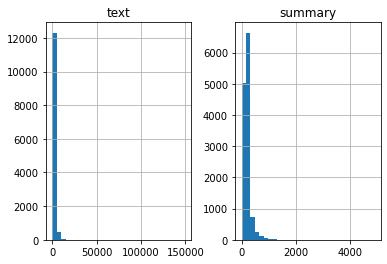

In [ ]:
import matplotlib.pyplot as plt

text_word_count = []
summary_word_count = []

# populate the lists with sentence lengths
for i in data['cleaned_text']:
      text_word_count.append(len(i.split()))

for i in data['cleaned_summary']:
      summary_word_count.append(len(i.split()))

length_df = pd.DataFrame({'text':text_word_count, 'summary':summary_word_count})

length_df.hist(bins = 30)
plt.show()

### Figuring out the size of articles and summaries.
This was used to test the limits of our model and computing power. We had to find the max we could train with, without crashing.


In [ ]:
#propotion of length of summaries
cnt=0
for i,j in zip(data['cleaned_summary'],data['cleaned_text']):
    if(len(i.split())>=100 and len(i.split())<=300 
      and len(j.split())>=200 and len(j.split())<=600):
        cnt=cnt+1
print(cnt/len(data['cleaned_summary']))

#75% of the data has  100 < sum_lenth  and 800 < text_length
#70% of the data has  100 < sum_length < 500 and 800 < text_length < 6000
#65% of the data has  100 < sum_length < 500 and 800 < text_length < 4000
#64% of the data has  100 < sum_length < 500 and 1000 < text_length < 5000
#60% of the data has  100 < sum_length < 500 and 1000 < text_length < 4000
#55% of the data has  100 < sum_length < 500 and 800 < text_length < 3000
#51% of the data has  100 < sum_length < 500 and 1000 < text_length < 3000
#47% of the data has  100 < sum_length < 500 and 800 < text_length < 2500

0.03476371537208039


### Some more data prep 
Here we add End and Start of sentence tokens. This is used for the encoder and decoder to know when the begining and end of a sentence is. 

In [ ]:
max_text_len=600
min_text_len=200

max_summary_len=300
min_summary_len=100

In [ ]:
#selecting summaries of desired length
cleaned_text =np.array(data['cleaned_text'])
cleaned_summary=np.array(data['cleaned_summary'])

short_text=[]
short_summary=[]

for i in range(len(cleaned_text)):
    if(len(cleaned_summary[i].split())<=max_summary_len and len(cleaned_summary[i].split())>=min_summary_len 
       and len(cleaned_text[i].split())<=max_text_len and len(cleaned_text[i].split())>=min_text_len):
        short_text.append(cleaned_text[i])
        short_summary.append(cleaned_summary[i])
        
df=pd.DataFrame({'text':short_text,'summary':short_summary})

In [ ]:
df['summary'] = df['summary'].apply(lambda x : 'sostok '+ x + ' eostok')

In [ ]:
for i in range(1):
  print("Article", i+1)
  print(df['text'][i])
  print('-'*100)
  print(df['summary'][i])

Article 1
coronavirus disease pandemic outbreak started china patients pneumonia unknown etiology symptoms presented dry cough sore throat diarrhea etiologic agent identified rna virus belonging coronaviridae family named sars cov epidemic progressed manifestations observed recalcati et al studied patients admitted lecco hospital lombardy italy patients skin reactions eight lesions occurred hospitalization reactions divided authors three forms erythematous rash widespread urticaria chickenpox like vesicles addition study case reported joob et al thailand case patient presented rash low platelet count initially misdiagnosed dengue evolved respiratory symptoms referred tertiary hospital tested positive sars cov despite existence skin lesions descriptions little information evolutions pictures therefore report one case following since prodromal period resolution symptoms female patient years old intensive care physician resident city recife pe hypothyroidism overweight comorbidities patie

### Train test split

In [ ]:
from sklearn.model_selection import train_test_split
x_tr,x_val,y_tr,y_val=train_test_split(np.array(df['text']),np.array(df['summary']),test_size=0.1,random_state=0,shuffle=True) 

# Prep the Tokenizer

In [ ]:
from keras.preprocessing.text import Tokenizer 
from keras.preprocessing.sequence import pad_sequences

#prepare a tokenizer for text on training data
x_tokenizer = Tokenizer() 
x_tokenizer.fit_on_texts(list(x_tr))

In [ ]:
thresh=4

cnt=0
tot_cnt=0
freq=0
tot_freq=0

for key,value in x_tokenizer.word_counts.items():
    tot_cnt=tot_cnt+1
    tot_freq=tot_freq+value
    if(value<thresh):
        cnt=cnt+1
        freq=freq+value
    
print("% of rare words in vocabulary:",(cnt/tot_cnt)*100)
print("Total Coverage of rare words:",(freq/tot_freq)*100)

% of rare words in vocabulary: 64.12434275148784
Total Coverage of rare words: 9.223225144208778


In [ ]:
#prepare a tokenizer for text on training data
x_tokenizer = Tokenizer(num_words=tot_cnt-cnt) 
x_tokenizer.fit_on_texts(list(x_tr))

#convert text sequences into integer sequences
x_tr_seq    =   x_tokenizer.texts_to_sequences(x_tr) 
x_val_seq   =   x_tokenizer.texts_to_sequences(x_val)

#padding zero upto maximum length
x_tr    =   pad_sequences(x_tr_seq,  maxlen=max_text_len, padding='post')
x_val   =   pad_sequences(x_val_seq, maxlen=max_text_len, padding='post')

#size of vocabulary ( +1 for padding token)
x_voc   =  x_tokenizer.num_words + 1

In [ ]:
print('number of words in body text learned by the tokenizer:', x_voc)

number of words in body text learned by the tokenizer: 6210


In [ ]:
#prepare a tokenizer for summary on training data
y_tokenizer = Tokenizer()   
y_tokenizer.fit_on_texts(list(y_tr))

In [ ]:
thresh=6

cnt=0
tot_cnt=0
freq=0
tot_freq=0

for key,value in y_tokenizer.word_counts.items():
    tot_cnt=tot_cnt+1
    tot_freq=tot_freq+value
    if(value<thresh):
        cnt=cnt+1
        freq=freq+value
    
print("% of rare words in vocabulary:",(cnt/tot_cnt)*100)
print("Total Coverage of rare words:",(freq/tot_freq)*100)

% of rare words in vocabulary: 78.76085697741748
Total Coverage of rare words: 17.527989502191694


In [ ]:
#prepare a tokenizer for summary on training data
y_tokenizer = Tokenizer(num_words=tot_cnt-cnt) 
y_tokenizer.fit_on_texts(list(y_tr))

#convert text sequences into integer sequences
y_tr_seq    =   y_tokenizer.texts_to_sequences(y_tr) 
y_val_seq   =   y_tokenizer.texts_to_sequences(y_val) 

#padding zero upto maximum length
y_tr    =   pad_sequences(y_tr_seq, maxlen=max_summary_len, padding='post')
y_val   =   pad_sequences(y_val_seq, maxlen=max_summary_len, padding='post')

#size of vocabulary
y_voc  =   y_tokenizer.num_words +1

In [ ]:
#y_voc size seems too small.
#first try increasing number of articles
print('number of words in summaries learned by the tokenizer:', y_voc)

number of words in summaries learned by the tokenizer: 1835


# Build the Model
We are finally at the model building part. But before we do that, we need to familiarize ourselves with a few terms which are required prior to building the model.

Return Sequences = True: When the return sequences parameter is set to True, LSTM produces the hidden state and cell state for every timestep

Return State = True: When return state = True, LSTM produces the hidden state and cell state of the last timestep only

Initial State: This is used to initialize the internal states of the LSTM for the first timestep

Stacked LSTM: Stacked LSTM has multiple layers of LSTM stacked on top of each other. This leads to a better representation of the sequence. I encourage you to experiment with the multiple layers of the LSTM stacked on top of each other (it’s a great way to learn this)

Bidirectional layer: Rather than just have the model look at the present and past words, a bidirectional layer looks ahead before encoding. This is essentially learning future context. It acomplishes this by running the LSTM in both directions, from the start and the end of a phrase.

The Latent Dimensions: (hidden)
The latent space of a model can be understood as a compressed representation of the data. The latent space is similar to how convolutions recognize edges or angles, it compresses the input into its most important features (reducing demensionality). The rest of the information not held by the latent space is discarded and the decoder must then learn to recreate the input from this latent space. The latent "space" referes to the new, reduced, dimensions of the input, the "space" that it now populates if we were to graph it. The bigger the latent space the less compression is done and the more features of the input the model remembers. Our biggest issue in ADS is memory. We could not train with a large latenet space, which begs the question; how similar can scientific papers be to eachother?

Here, we are building a 3 stacked LSTM for the encoder:

In [ ]:
from keras import backend as K 
K.clear_session()

latent_dim = 200
embedding_dim=100

# Encoder
encoder_inputs = Input(shape=(max_text_len,))

#embedding layer
enc_emb =  Embedding(x_voc, embedding_dim,trainable=True)(encoder_inputs)

#encoder lstm 1
encoder_lstm1 = LSTM(latent_dim,return_sequences=True,return_state=True,dropout=0.4,recurrent_dropout=0.4)
encoder_output1, state_h1, state_c1 = encoder_lstm1(enc_emb)

#encoder lstm 2
encoder_lstm2 = LSTM(latent_dim,return_sequences=True,return_state=True,dropout=0.4,recurrent_dropout=0.4)
encoder_output2, state_h2, state_c2 = encoder_lstm2(encoder_output1)

#encoder lstm 3
encoder_lstm3=LSTM(latent_dim, return_state=True, return_sequences=True,dropout=0.4,recurrent_dropout=0.4)
encoder_outputs, state_h, state_c= encoder_lstm3(encoder_output2)

# Set up the decoder, using `encoder_states` as initial state.
decoder_inputs = Input(shape=(None,))

#embedding layer
dec_emb_layer = Embedding(y_voc, embedding_dim,trainable=True)
dec_emb = dec_emb_layer(decoder_inputs)

decoder_lstm = LSTM(latent_dim, return_sequences=True, return_state=True,dropout=0.4,recurrent_dropout=0.2)
decoder_outputs,decoder_fwd_state, decoder_back_state = decoder_lstm(dec_emb,initial_state=[state_h, state_c])

# Attention layer
attn_layer = AttentionLayer(name='attention_layer')
attn_out, attn_states = attn_layer([encoder_outputs, decoder_outputs])

# Concat attention input and decoder LSTM output
decoder_concat_input = Concatenate(axis=-1, name='concat_layer')([decoder_outputs, attn_out])

#dense layer
decoder_dense =  TimeDistributed(Dense(y_voc, activation='softmax'))
decoder_outputs = decoder_dense(decoder_concat_input)

# Define the model 
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)

model.summary() 

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 600)]        0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 600, 100)     621000      input_1[0][0]                    
__________________________________________________________________________________________________
lstm (LSTM)                     [(None, 600, 200), ( 240800      embedding[0][0]                  
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, None)]       0                                            
______________________________________________________________________________________________

In [ ]:
model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy')

In [ ]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1,patience=2)


In [ ]:
history=model.fit([x_tr,y_tr[:,:-1]], y_tr.reshape(y_tr.shape[0],y_tr.shape[1], 1)[:,1:] ,epochs=100,batch_size=16, validation_data=([x_val,y_val[:,:-1]], y_val.reshape(y_val.shape[0],y_val.shape[1], 1)[:,1:]))

Epoch 1/100
26/26 [==============================] - 193s 7s/step - loss: 4.7524 - val_loss: 2.9166
Epoch 2/100
26/26 [==============================] - 169s 7s/step - loss: 3.1100 - val_loss: 2.8555
Epoch 3/100
26/26 [==============================] - 171s 7s/step - loss: 3.0428 - val_loss: 2.8515
Epoch 4/100
26/26 [==============================] - 172s 7s/step - loss: 2.9536 - val_loss: 2.8184
Epoch 5/100
26/26 [==============================] - 176s 7s/step - loss: 3.0719 - val_loss: 2.8148
Epoch 6/100
26/26 [==============================] - 173s 7s/step - loss: 2.9362 - val_loss: 2.8045
Epoch 7/100
26/26 [==============================] - 171s 7s/step - loss: 3.0130 - val_loss: 2.8053
Epoch 8/100
26/26 [==============================] - 180s 7s/step - loss: 2.9516 - val_loss: 2.7928
Epoch 9/100
26/26 [==============================] - 172s 7s/step - loss: 2.8559 - val_loss: 2.7729
Epoch 10/100
26/26 [==============================] - 173s 7s/step - loss: 2.9188 - val_loss: 2.7794

In [ ]:
#plot training
from matplotlib import pyplot
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

It is interesting to note, that continuting training does increase document summary "legibility"

## Encoder and Decoder



In [ ]:
reverse_target_word_index=y_tokenizer.index_word
reverse_source_word_index=x_tokenizer.index_word
target_word_index=y_tokenizer.word_index

In [ ]:
# Encode the input sequence to get the feature vector
encoder_model = Model(inputs=encoder_inputs,outputs=[encoder_outputs, state_h, state_c])

# Decoder setup
# Below tensors will hold the states of the previous time step
decoder_state_input_h = Input(shape=(latent_dim,))
decoder_state_input_c = Input(shape=(latent_dim,))
decoder_hidden_state_input = Input(shape=(max_text_len,latent_dim))

# Get the embeddings of the decoder sequence
dec_emb2= dec_emb_layer(decoder_inputs) 
# To predict the next word in the sequence, set the initial states to the states from the previous time step
decoder_outputs2, state_h2, state_c2 = decoder_lstm(dec_emb2, initial_state=[decoder_state_input_h, decoder_state_input_c])

#attention inference
attn_out_inf, attn_states_inf = attn_layer([decoder_hidden_state_input, decoder_outputs2])
decoder_inf_concat = Concatenate(axis=-1, name='concat')([decoder_outputs2, attn_out_inf])

# A dense softmax layer to generate prob dist. over the target vocabulary
decoder_outputs2 = decoder_dense(decoder_inf_concat) 

# Final decoder model
decoder_model = Model(
    [decoder_inputs] + [decoder_hidden_state_input,decoder_state_input_h, decoder_state_input_c],
    [decoder_outputs2] + [state_h2, state_c2])

In [ ]:
def decode_sequence(input_seq):
    # Encode the input as state vectors.
    e_out, e_h, e_c = encoder_model.predict(input_seq)
    
    # Generate empty target sequence of length 1.
    target_seq = np.zeros((1,1))
    
    # Populate the first word of target sequence with the start word.
    target_seq[0, 0] = target_word_index['sostok']

    stop_condition = False
    decoded_sentence = ''
    while not stop_condition:
        #print('here')
        output_tokens, h, c = decoder_model.predict([target_seq] + [e_out, e_h, e_c])

        # Sample a token
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        #print(sampled_token_index)

    #***for some reason the decoder breaks when sampled_token_index=0 t
        if(sampled_token_index == 0):sampled_token_index = sampled_token_index+1
    #****
        sampled_token = reverse_target_word_index[sampled_token_index]
        #sampled_token = reverse_source_word_index[sampled_token_index]
        
        if(sampled_token!='eostok'):
            decoded_sentence += ' '+sampled_token

        # Exit condition: either hit max length or find stop word.
        if (sampled_token == 'eostok'  or len(decoded_sentence.split()) >= (max_summary_len-1)):
            stop_condition = True

        # Update the target sequence (of length 1).
        target_seq = np.zeros((1,1))
        target_seq[0, 0] = sampled_token_index

        # Update internal states
        e_h, e_c = h, c

    return decoded_sentence


In [ ]:
def seq2summary(input_seq):
    newString=''
    for i in input_seq:
        if((i!=0 and i!=target_word_index['sostok']) and i!=target_word_index['eostok']):
            newString=newString+reverse_target_word_index[i]+' '
    return newString

def seq2text(input_seq):
    newString=''
    for i in input_seq:
        if(i!=0):
            newString=newString+reverse_source_word_index[i]+' '
    return newString

## Generated Abstractive Summaries:

In [ ]:
for i in range(0,10):
    print("Review:",seq2text(x_tr[i]))
    print("Original summary:",seq2summary(y_tr[i]))
    print("Predicted summary:",decode_sequence(x_tr[i].reshape(1,max_text_len)))
    print("\n")

# Extractive Summarizer
This is an entirely different approach to text processing for creating summaries. Instead of using an abstractive layer to create original text to then turn into a summary, the extractive approach instead takes all of the sentences in the original article and places them into a probability matrix to calculate how often a sentence that is simailar to itself appears in the document. After that process you simply print out the top n sentences and combine them to create a summary.

This approach has the benefit of creating sentences that are grammatically correct, with the downfall being that the transitions between sentences might be completely missing or nonsensical.

In [ ]:
# download pretrained GloVe word embeddings
! wget http://nlp.stanford.edu/data/glove.6B.zip
nltk.download('stopwords')# one time execution
from nltk.corpus import stopwords
stop_words = stopwords.words('english')

--2020-12-18 01:16:36--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2020-12-18 01:16:36--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2020-12-18 01:16:37--  http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glove.6

In [ ]:
df = data
! unzip glove*.zip

Archive:  glove.6B.zip
  inflating: glove.6B.50d.txt        
  inflating: glove.6B.100d.txt       
  inflating: glove.6B.200d.txt       
  inflating: glove.6B.300d.txt       


## Extractive Summarizer Function

In [ ]:
  # Extract word vectors
  word_embeddings = {}
  f = open('glove.6B.100d.txt', encoding='utf-8')
  for line in f:
      values = line.split()
      word = values[0]
      coefs = np.asarray(values[1:], dtype='float32')
      word_embeddings[word] = coefs
  f.close()

In [ ]:
from sklearn.metrics.pairwise import cosine_similarity
import networkx as nx

# function to remove stopwords
def remove_stopwords(sen):
  sen_new = " ".join([i for i in sen if i not in stop_words])
  return sen_new

def summarizer(text, original_length=10000, summary_length=2000, max_sentences=10,article_num=-1):

  # split the the text in the articles into sentences
  sentences = []
  for s in text[:1]:
    sentences.append(sent_tokenize(s)) 

  # flatten the list
  sentences = [y for x in sentences for y in x]


  # remove punctuations, numbers and special characters
  clean_sentences = pd.Series(sentences).str.replace("[^a-zA-Z]", " ")

  # make alphabets lowercase
  clean_sentences = [s.lower() for s in clean_sentences]

  # remove stopwords from the sentences
  clean_sentences = [remove_stopwords(r.split()) for r in clean_sentences]

  sentence_vectors = []
  for i in clean_sentences:
    if len(i) != 0:
      v = sum([word_embeddings.get(w, np.zeros((100,))) for w in i.split()])/(len(i.split())+0.001)
    else:
      v = np.zeros((100,))
    sentence_vectors.append(v)

  # The next step is to find similarities among the sentences. We will use cosine similarity to find similarity between a pair of sentences. Let's create an empty similarity matrix for this task and populate it with cosine similarities of the sentences.

  # similarity matrix
  sim_mat = np.zeros([len(sentences), len(sentences)])

  for i in range(len(sentences)):
    for j in range(len(sentences)):
      if i != j:
        sim_mat[i][j] = cosine_similarity(sentence_vectors[i].reshape(1,100), sentence_vectors[j].reshape(1,100))[0,0]


  nx_graph = nx.from_numpy_array(sim_mat)
  scores = nx.pagerank(nx_graph)
  
  # order the sentences in the order of the ranks of the rank matrix
  ranked_sentences = sorted(((scores[i],s) for i,s in enumerate(sentences)), reverse=True)

  # Generate output
  original = ""
  for i in sentences:
    original = original + " " + i

  if(len(original) > original_length):
    original = original[:original_length] + "..."

  display(Markdown('## Article #'+ str(article_num) + ':'))
  display(Markdown(original))

  # Generate summary
  display(Markdown('## Summary:'))
  summary = ""
  for i in range(max_sentences):
    summary = summary + " " + ranked_sentences[i][1]

  if(len(summary) > summary_length):
    summary = summary[:summary_length] + "..."

    
  display(Markdown(summary))

In [ ]:
for i in range(20):
  if(i !=2):
    summarizer(df["Text"][i:i+1], original_length=2000, summary_length=400, max_sentences=5,article_num=i+1)


## Article #1:

 Use of Personal Protective Equipment (PPE) has been a central behavioural and policy response to control spread of the SARS-CoV2 virus during the global COVID-19 pandemic. In particular masks, and sometimes gloves, aprons, gowns, and face/eye protection have been recommended or used in high-risk situations such as healthcare settings or enclosed public spaces. The resultant surge in demand for PPE has required an increase in PPE production, including an estimated 11% increase in global production of gloves this year. (1)Whereas there is evidence that PPE is effective in limiting transmission of the SARS-CoV2 virus, the necessity and extent of PPE for use in different circumstances is still subject to debate. (2) Excessive use of PPE risks generating unnecessary financial cost: for example, by early July 2020 the UK government had allocated GBP £15bn of funds for purchasing PPE for public sector workers. (3) In addition, use of PPE generates a cost to the environment (which in turn impacts on human health), but to date that risk has not been quantified.Here we use the approach of life cycle assessment (LCA) to estimate emissions and resulting environmental impact from the most common PPE items prescribed and used in the National Health Service (NHS) and public social care sector in England: masks, gloves, aprons, gowns, and face/eye protection. (4) We equate this with data on the volumes of these products supplied to health and social care services in England in the first six months of the COVID-19 pandemic, to estimate the overall environmental impact of PPE over this time period. We evaluate the associated damage to human health (measured in disability adjusted life years), ecosystems (loss of local species), and resource scarcity (financial cost involved in future mineral and fossil resource extraction). (5) We model a number of approaches which could reduce such impact, and which could inform future policy on use and supply of PPE.We based our analysis on produc...

## Summary:

 CO 2 e= carbon dioxide equivalents, FFP= filtering facepieceEnvironmental impacts (endpoint categories) of alternative scenarios, modelled on total volumes of core PPE supplied to health and social care services in England between 25 th February and 23 rd August 2020, normalised to highest scenario for each impact factor, modelling base scenario (air freight, single-use PPE, clinical waste), use ...

## Article #2:

 We developed a deterministic compartmental transmission model of SARS-CoV-2 in a population stratified by disease status (susceptible, exposed, infectious with mild or severe disease, diagnosed, and recovered) and disease awareness status (aware and unaware) due to the spread of COVID-19. Self-imposed measures were assumed to be taken by diseaseaware individuals and included handwashing, mask-wearing, and social distancing. Government-imposed social distancing reduced the contact rate of individuals irrespective of their disease or awareness status. The model was parameterized using current best estimates of key epidemiological parameters from COVID-19 clinical studies. The model outcomes included the peak number of diagnoses, attack rate, and time until the peak number of diagnoses. For fast awareness spread in the population, self-imposed measures can significantly reduce the attack rate and diminish and postpone the peak number of diagnoses. We estimate that a large epidemic can be prevented if the efficacy of these measures exceeds 50%. For slow awareness spread, self-imposed measures reduce the peak number of diagnoses and attack rate but do not affect the timing of the peak. Early implementation of shortterm government-imposed social distancing alone is estimated to delay (by at most 7 months for a 3-month intervention) but not to reduce the peak. The delay can be even longer and the height of the peak can be additionally reduced if this intervention is combined with self-imposed measures that are continued after government-imposed social distancing has been lifted. Our analyses are limited in that they do not account for stochasticity, demographics, heterogeneities in contact patterns or mixing, spatial effects, imperfect isolation of individuals with severe disease, and reinfection with COVID-19.Our results suggest that information dissemination about COVID-19, which causes individual adoption of handwashing, mask-wearing, and social distancing, can be an e...

## Summary:

 This means that, for fast spread of awareness, a large outbreak can be prevented by, for example, a combination of handwashing and self-imposed social distancing, each with an efficacy of around 25% (or other efficacies adding up to 50%).For many countries around the world, the focus of public health officers in the context of COVID-19 epidemic has shifted from containment to mitigation and delay...

## Article #4:

 Estimating the field effectiveness of influenza vaccines (VE) poses specific challenges for the 2009 A(H1N1) pandemic. In particular, both pandemic and seasonal vaccination campaigns took place during the epidemic and, as a consequence, vaccine coverage changed through time, both in influenza cases and in the population as a whole.In France, pandemic vaccination conformed to a priority list established by public health authorities based on exposure and/or transmission probability, or on risk of complication subsequent to influenza [1] . The priority allocation of pandemic vaccines is shown in Figure 1 , along with the evolution of vaccine coverage over time, by broad age categories. Medical and paramedical staffs working in hospitals were first called, on October 20 th (week 43). Individuals working with ambulatory patients presenting with influenza or working with patients at high risk of complication for influenza were called on November 2 nd (week 45). Risk factors of complication, stated in a High Committee of Public Health advice, on September 7 th 2009, were: pregnancy (in particular from the second trimester), obesity, and chronic conditions such as broncopulmonary diseases, heart diseases, diabetes and immunosuppression [2] . On November 12 th (week 46) all other health care professional were called (880,000), as well as all persons in contact with infants younger than six month-old (1,200,000), childminders working with children under three year-old (500,000), and every person between six months and 64 years of age with a risk factor (2,815,000). Pregnant women from their second trimester and 6-to 23 month-old children without risk factor were called on November 20 th (week 47). High school pupils were called on November 25 th (week 48). People over 65 year-old with a risk factor (3, 200 ,000) and children older than 23 month-old (7,700,000) and were called in week 49. Finally, adults over 18 year-old without a risk factor were called in week 53 (39,000,00...

## Summary:

 A subsequent paper evidenced a moderate effectiveness of the 2008-2009 seasonal vaccines against pandemic A(H1N1) mild outcomes (VE = 42%, 29-53%) [31] , while another one put forward an increased risk (odds-ratio = 2.45, 1.34-4.48) [32] .Regarding the effectiveness of the 2009-2010 seasonal vaccines, most works found no protection against confirmed pandemic A(H1N1) [8, 23, [33] [34] [35] [36] , ...

## Article #5:

 COVID-19 pandemic reached 3.78 million confirmed reported cases worldwide, and it is generally associated to the acronym that precedes its name: severe acute respiratory syndrome (SARS). However, the bottom of the iceberg is being progressively unveiled since it is far more than simply a severe interstitial pneumonia. There is a gap in knowledge of pathophysiological process that allows COVID-19 to be considered a multi-organ disease in all respects.We looked for main papers about SARS and COVID-19 as systemic diseases, focusing on cardiovascular, renal, liver, nervous, and reproductive systems.The SARS-COV-2 virus not only causes viral pneumonia; however, it also has major implications for the cardiovascular system, but the extent, severity, and duration are still to be defined. In a study of 75 patients, two patients had succumbed to acute myocardial infarction [1] .A study from Huang et al. demonstrated that myocardial injury, defined by an increase in hs-cTnI levels (> 28 pg/mL), occurred on 5 out of 41 COVID-19 patients. Noteworthy is the fact that 80% of these patients required ICU management demonstrating that myocardial damage in SARS-COV-2 infection is severe [2] .A prospective study investigating left ventricular performance in 46 patients with severe acute respiratory syndrome showed subclinical diastolic impairment without systolic involvement [3] . Another study in 121 patients with SARS identified cardiovascular complications including tachycardia (72%), hypotension (50%), bradycardia (15%), transient cardiomegaly (11%), and transient paroxysmal atrial fibrillation in only 1 patient, although usually self-limiting [4] . A study from Singapore reported postmortem examinations: the presence of pulmonary embolism (PE) and deep vein thrombosis and acute myocardial infarction is of great clinical interest, but the generalizability of this limited study is not established [5] . Anyway, it is well recognized that SARS-COV-2 infection alters coagulation pathw...

## Summary:

 ANE is a rare complication of influenza and other viruses resulting from intracranial cytokine storm and resulting in blood-brain barrier damage, plausible with COVID-19 pathogenetic signature.Although metabolic and electrolyte derangements, especially in thalamocortical pathways, secondary to COVID-19 are plausible causes of clinical or subclinical acute symptomatic seizures and status epileptic...

## Article #6:

 On March 11 st , 2020, the World Health Organization (WHO) declared the ongoing outbreak of nCoV-2019 as a pandemic public health emergency. As of April 5 th , 2020, more than 1.200.000 confirmed SARS-CoV-2 cases have been reported globally. Of these, more than 124.000 were from Italy.The SARS-CoV-2 can manifest principally as severe pneumonia, Acute Respiratory Distress Syndrome (ARDS), and Multiple-Organ Failure (MOF), which can lead to death. The SARS-CoV-2 can be transmitted from human to human through respiratory droplets, contact, and even fecaloral transmission (1, 2) .Imaging plays an important role in the diagnosis and management of SARS-CoV-2, in particular in the case of pneumonia. Computed Tomography (CT) is considered the first-line imaging modality in highly suspected cases and helps to monitor pathological changes during treatment. Typical CT feature is the bilateral distribution of ground-glass opacities (GGOs) with or without consolidation in posterior and peripheral areas of lungs, as the cardinal hallmark of SARS-CoV-2 (3, 4, 5) .On the other hand, the routine chest X-ray is the most widely available radiological procedure during hospital admissions, in particular, to complete differential diagnosis of respiratory symptoms, such as cough and dyspnea. The chest radiograph can establish the presence of pneumonia, define its extension and location, and can also diagnose complications. However limited information exists regarding chest X-ray imaging findings of SARS-CoV-2 lung infection (6) .Overall, due to the increasing number of reported cases of SARS-CoV-2 infection, radiologists encounter more frequently patients in the emergency setting. The goal of the radiological emergency department is to quickly undertake the diagnosis and evaluation of patients with suspected SARS-CoV-2 and provide frontline diagnosis and confirmation of the disease. A chest Xray may help in early detection of lung abnormalities for screening outpatients with highly suspe...

## Summary:

 Moreover, we found out that consolidation is statistically associated with age > 60 years old and not associated with symptoms onset (p<0.0001 and p=0.924 respectively), and, consistently with previous studies, SARS-CoV-2 was more often found in men than in women (9, 10, 11, 12, 13).A chest radiograph can establish the presence of pneumonia, define its extension and location, and can also diagnos...

## Article #7:

 Influenza viruses belong to the Orthomyxoviridae family, whose members are defined by a segmented, single-stranded, negative-sense RNA genome (which is replicated in the nucleus) and an envelope that is derived from the host cell [1] . Influenza A viruses have eight genome segments that encode for 10 or 11 viral proteins, depending on the strain. Nine of these proteins are found in the virion. These include: the HA, NA and M2 proteins, which are all inserted into the lipid envelope; the matrix (M1) protein which lies beneath the membrane; the NP which coats the viral genome; the polymerase complex (PB1, PB1, PA) which is associated with the encapsidated genome, and the nuclear export protein (NEP). The remaining viral proteins, NS1 and PB1-F2, are expressed in infected cells but are not packaged into the virus particle.Influenza virus initiates infection via attachment of HA to sialic acid-containing proteins on the host cell membrane (Figure 1 ). The virus particle then enters the cell by pH-dependent endocytosis, although there appears to be flexibility in the pathway that is used, with an estimated two thirds using a clathrin-dependent pathway and the remaining third entering via an undefined pathway that is independent of both clathrin and caveolin [2] . Once in the acid environment of the late endosome, the HA undergoes a conformational change and drives fusion of the viral envelope with that of the endosome [3] . In addition, the M2 protein, which has ion channel activity [4] , pumps H+ ions into the interior of the virion and this dissociates M1 from the viral ribonucleoprotein complexes (vRNPs). The released vRNPs enter the cytoplasm through the fusion pore and are transported into the nucleus via interaction of NP with karyopherin alpha proteins [5] , which are part of the nuclear import machinery. Once in the nucleus, the incoming viral polymerase complex initiates genome transcription. In a process known as "cap-snatching", the PB2 protein binds to the 5...

## Summary:

 Some of these cellular factors may be specifically required by influenza virus, while others may also play a role in other virus infections, which presents the opportunity for development of a host-directed drug with broad-spectrum activity.RNA interference siRNA small inhibitory RNA vRNPs viral ribonucleoprotein complexes Representation of the number of common hits amongst five influenza virus R...

## Article #8:

 The COVID-19 pandemic is a rapidly evolving global emergency, which looks set to become a longterm challenge for society. Patients who are hospitalized with COVID-19 may be treated with multiple drugs, including experimental treatments and adjuvant therapies, in addition to any concomitant medications already prescribed to the patient. As such, it is vital for clinicians to be able to quickly and easily integrate as much information as possible, particularly about patient-specific factors, such as genetic variants, to optimize treatment.The Pharmacogenomics Knowledgebase (PharmGKB) has curated pharmacogenomic (PGx) knowledge since 2000 (1) . This wealth of information about the impact of genetic variation on drug response collected from research publications, regulator-approved drug labels, clinical guidelines and other sources is freely available to all through the PharmGKB website (https://www.pharmgkb.org). Although the majority of PharmGKB content is collected and curated manually by expert scientific curators, automated annotations of PubMed abstracts and full-text articles in PubMed Central can also be accessed by users (2) .In response to this pandemic, PharmGKB has produced a COVID-19 portal to bring together relevant pharmacogenomic resources from across the site as well as some links to external materials. The use of pharmacogenomic information should only form part of the prescribing decision-making process and must be considered alongside other factors, including concomitant medications and drug-drug interactions. This tutorial paper will guide users through the information presented in the COVID-19 portal and provide an introduction to navigating the PharmGKB website.The PharmGKB COVID-19 portal can be accessed at https://www.pharmgkb.org/page/covid. It is currently also available via the red button displayed on the PharmGKB homepage or users can search for COVID-19 in the search box and follow the link given on the COVID-19 disease page to theThis art...

## Summary:

 Clicking on each resource name takes the user to an overview of all of the annotations of that type.Some experimental COVID-19 treatments do not currently have any pharmacogenomic information available, either because they are awaiting approval from the U.S. Food and Drug Administration (FDA) or because pharmacogenomic studies of these drugs have not yet been carried out. The portal is updated on...

## Article #9:

 Rudolf Virchow , one of the foremost 19th century German leaders in medicine and pathology [1] , noted a relationship between human diseases and animals and then introduced the term "zoonosis" (plural: zoonoses) in 1880 [2] . Later, the World Health Organization (WHO) in 1959 specified that "zoonoses are those diseases and infections which are naturally transmitted between vertebrate animals and man" [3] . Venkatesan and co-authors reported that the term zoonosis is derived from the Greek word "zoon" = animal and "noso" = disease [4] . Zoonotic pathogens causing different kinds of diseases are of major public health issues worldwide [5] . These zoonotic diseases includeFrequent mixing of different animal species in the markets in densely populated areas, and the human intrusions into the natural habitats of animals, have facilitated the emergence of novel viruses. The most important zoonotic viral diseases of which eight were diagnosed (in dead or diseased animals or through antibody detection) on the Arabian Peninsula over the last years include rabies, Middle East Respiratory Syndrome (MERS-CoV), influenza virus (IFV), Alkhurma hemorrhagic fever, Crimean-Congo hemorrhagic fever (CCHF), Rift Valley fever (RVF), West Nile fever (WNV), and dengue fever virus. Among these eight zoonotic viral diseases, two (Alkhurma and MERS-CoV) were first reported in a patient in 1994 and 2012, respectively in Saudi Arabia [33, 34] . These two were transmitted later to several other countries, not only in the Middle East but also to Africa, Asia, and Europe.Rabies is an almost invariably fatal zoonotic disease, which belongs to the genus Lyssavirus of the RNA family Rhabdoviridae. Rabies virus is considered an endemic viral infectious disease in animals in Saudi Arabia. Recent scientific data on rabies cases reported in camels at Al-Qassim region (one of the thirteen administrative regions of Saudi Arabia) showed that there is an increasing number of this fatal virus disease [35] ....

## Summary:

 It was further suggested that the virus may have been introduced via unlawful entrance of viremic domestic or wild animals through the borders or through vectors that carry the virus into Turkey [209] .Camels play an important role in public health issues regarding zoonosis and they have been involved in most of the zoonotic infections which occurred in Saudi Arabia in the last three decades. How...

## Article #10:

 At the time of writing, the COVID-19 pandemic had already caused more than half a million deaths worldwide; at the time of re-writing, some weeks later, this number was approaching one million. The effects of the virus have been widespread and substantial, from the collapse of healthcare systems [1] [2] [3] to the enforcement of isolation and quarantine. In the case of Nepal, the national lockdown lasted for 120 days uninterrupted [4] .In these circumstances, identifying reliable and effective disease control policies is of utmost importance. Here by "policy" we mean a deliberate intervention intended to mitigate the effects of a disease as it runs its course. In much of the mathematical literature on epidemiology, the process of generating a policy is as follows [5] : (1) based on their intuition, expert epidemiologists propose a number of suitable policies to control the disease; (2) the impact on the population of each of the considered policies is assessed through dynamical models of disease spread; (3) the outcomes of all policies are compared and a decision is taken as to which one is deemed to be the best.This three-step process has two disadvantages. First of all, the class of policies devised by an expert could well be suboptimal, since the optimal policy (under some figure of merit) could be extremely complicated and counterintuitive. Second, the method requires one to numerically simulate each policy. Given the exponential growth of the number of policies in the number of control parameters, the number of policies considered may be on the order of billions; hence, this strategy is not guaranteed to identify the optimal disease control policy in time to enforce it.In this paper we formulate the problem of identifying an optimal policy for disease control as an optimization problem. Using tools from optimization theory and machine learning [6] , we propose efficient heuristics to find optimal disease policies for a given model of a disease.To illustrate th...

## Summary:

 Although in the following all our proposed policies are non-adaptive, the formalism we introduce allows one to optimize over adaptive policies as well.In conclusion, a disease control policy can always be identified with a vector function α of the time t and perhaps some other observed variables o, where each vector entry represents a type of government intervention at time t. In turn, we can use...

## Article #11:

 Respiratory viral infections are a significant cause of morbidity and mortality globally (Esposito et al., 2013; Huijskens et al., 2013) . Early identification of respiratory pathogens permits rapid implementation of appropriate infection control precautions, decreased antibiotic use and where appropriate, initiation of antiviral therapies (Barenfanger et al., 2000; Heinonen et al., 2011) . Traditional laboratory methods such as viral culture and direct fluorescent-antibody testing are time consuming and lack sensitivity, and are no longer the method of choice (Gharabaghi et al., 2011; She et al., 2010) . Currently, molecular methods are now standard and are employed in most virology laboratories. Multiplexed assays have enabled the detection of several viral targets and permit the simultaneous identification of co-infections in patient specimens (Esper et al., 2011) . There are currently several multiplex assays available commercially. Three such Health Canada approved assays include the Seeplex RV15 ACE Detection Kit (RV15) (Seegene, South Korea), the Anyplex II RV16 (RV16) (Seegene, South Korea) and the xTAG Respiratory Viral Panel (xTAG) (Luminex, United States)The RV15 is a multiplex assay based on dual priming oligonucleotide (DPO) technology (Bruijnesteijn van Coppenraet et al., 2010) . The list of fifteen detectable viruses include: influenza A virus (INF A), influenza B virus (INF B), respiratory syncytial viruses A and B (RSVA and RSVB), adenovirus (ADV), human metapneumovirus (hMPV), coronavirus OC43 (CoV OC43), parainfluenza viruses (PIV) 1-4, rhinovirus (RhV) A to C, enterovirus (EV), and Bocaviruses (BoV).The RV16 is based on Tagged Oligo Cleavage Extension (TOCE™) technology, which makes it possible to detect multiple pathogens in a single fluorescence channel using real time PCR (Kim et al., 2013) . The RV16 can detect a total of 16 viruses including serotypes of each virus. The RV16 viral panel is identical to the RV15 viral panel with the addition...

## Summary:

 The Luminex xTag system is a liquid-bead-suspension-array that is based on multiplex PCR (Jokela et al., 2012) T bocaviruses were previously not included on the viral panel for xTAG; however, version 2 being analyzed in this study has this viral target as part of its testing panel.Thus, this study aims to compare the diagnostic performance of the RV16 and xTAG assays to that of the RV15, as the t...

## Article #12:

 IMPORTANCE YFV-17D is a live attenuated flavivirus vaccine strain recognized as one of the most effective vaccines ever developed. However, the host and viral determinants governing YFV-17D attenuation and its potent immunogenicity are still unknown. Here, we analyzed the role of type III interferon (IFN)-mediated signaling, a host immune defense mechanism, in controlling YFV-17D infection and attenuation in different mouse models. We uncovered a critical role of type III IFN-mediated signaling in preserving the integrity of the blood-brain barrier and preventing viral brain invasion. Type III IFN also played a major role in regulating the induction of a potent but balanced immune response that prevented viral evasion of the host immune system. An improved understanding of the complex mechanisms regulating YFV-17D attenuation will provide insights into the key virus-host interactions that regulate host immune responses and infection outcomes as well as open novel avenues for the development of innovative vaccine strategies. KEYWORDS flavivirus, innate immunity, interferons, live vector vaccines, yellow fever virus A rthropod-borne flaviviruses such as dengue virus (DENV), yellow fever virus (YFV), and Zika virus (ZIKV) are a cause of major health concerns worldwide (1) (2) (3) . With a mortality rate of up to 25% to 50%, YFV infection is one of the most severe flavivirus infections and is responsible for around 200,000 new infections and 30,000 deaths each year (2) . The YFV live attenuated strain YFV-17D is one of the safest and most potent vaccines ever developed (4) . The vaccination of more than 500 million individuals over the past 80 years has significantly contributed to the prevention of YFV outbreaks (4) . However, vaccination coverage has decreased over the last few decades, and recent outbreaks in Africa and South America have highlighted the urgent need for reassessing strategies to control YFV infection worldwide (5) .The intricate interplay between YF...

## Summary:

 Numbers of B cells were significantly reduced in the blood and liver of ␣␤R Ϫ/Ϫ R Ϫ/Ϫ mice, suggesting a potential effect on B-cell-mediated control of YFV-17D infection. Taken together, results from our study support a model in which severe viral neuroinvasion in ␣␤R Ϫ/Ϫ R Ϫ/Ϫ mice could be caused by the convergence of three major elements: active viral replication, increased BBB permeability, a...

## Article #13:

 (1) Introduction:For centuries humanity had speculated about the existence of other planets orbiting other stars to our own. 25 years ago the discovery of a planet orbiting the solar-like star 51 Peg (Mayor & Queloz, 1995) opened the floodgates, leading to a vigorous expansion in the number of known exoplanets.51 Peg was the first widely accepted exoplanet discovered orbiting a solar-like star, using radial velocity measurements just as Struve (1952) had suggested could result in such a discovery of a massive planet close to its host: `A planet ten times the mass of Jupiter would be easy to detect, since it would cause the observed radial velocity of the star to oscillate with ± 2 km per second'. It is worth noting that 51 Peg was not the first exoplanet to be found. Radio pulsar timings by Wolszczan & Frail (1992) had provided convincing evidence to planetary masses outside our solar system. The radial velocity work of Latham et al. (1989) and Hatzes & Cochran (1993) had provided evidence suggesting objects of planetary masses orbiting main sequence stars. Similarly, Campbell et al. (1988) proposed a planetary candidate in a 2.7 year orbit in the binary Gamma Cephei system, based on a radial velocity curve of 25 metre per second amplitude. However and later cast doubt on the interpretation, noting that their velocity standards showed roughly annual variations that correlated with their chromospheric activity. Walker et al. (1992) refined the period to 2.52 years noting that "an explanation… in terms of … a Jupiter-mass planet in a high circular orbit …is still viable" but expressed concern that such a massive planet could truly exist so close to its host star. Indeed, the strange nature of 51 Peg's planet (an orbital radius some 5% that of Earth's, a 4.23 day orbit, and a mass similar to Jupiter's) raised eyebrows at the time of its discovery announcement. The field of planet discoveries had had many false alarms in the past, such as Peter van de Kemp's claims tha...

## Summary:

 A similar analysis would be needed for the radial velocity data and is something planned for the next iteration of the course at Harper College, now that we know that the students are able to reach this kind of analysi Even a cursory examination of the summary pages of the NEA show clearly the wide range of statistical error estimates for a given system, which can be orders of ten in size.Two stu...

## Article #14:

 Bioaerosols are present virtually anywhere in the environment, and their exposure is shown to cause numerous adverse health effects [1] [2] . In addition, there is also a possible release of biowarfare agents in a man-made bio-terror event. A number of studies demonstrated that the respiratory tract can be colonized with disease organisms [3] [4] [5] . Through talking, coughing, sneezing or singing, the potential virulent organisms can be exhaled and spread into the ambient environment [6] , which accordingly causes air contamination. For example, SARS in 2003 and H1N1 in 2009 outbreaks were shown to be attributed to the airborne route of disease transmission [7] [8] [9] [10] .Among many other diseases, respiratory infection accounts for 23.3-42.1% of the total hospital infections [11] , and is listed as the third leading killer [12] . However, present diagnosis procedures using nasal swabs, bronchoalveolar lavages, nasopharyngeal aspirates or sputum samples, appear to cause unpleasant experiences in addition to long detection time. During flu outbreaks, body temperature or isolation procedures are often used to control and prevent further spread, however such methods are lacking scientific evidence and not always effective with those patients infected but in latent period. On another front, exhaled breath condensate (EBC) as a simple and noninvasive method is increasingly being utilized in early disease screening and infectious aerosols measurements, e.g., lung cancer [13, 14] , asthma [15, 16] , and other respiratory problems [17, 18] . In previous studies, human influenza A viruses were detected in exhaled breath using EBC [19, 20] as well as filter [21] , mask [22, 23] and a liquid sampler [24] . In another study, foot-and-mouth disease viruses were also found in the exhaled air from experimentally infected cattle [25] . In addition, high levels of bacterial concentrations in EBC were also observed in other studies [26] [27] [28] [29] . It was recently shown th...

## Summary:

 Results shown in Figures 5, 6 , 7, and 8 indicate that high levels of bacterial aerosols were detected in the EBC samples collected, and the results on the other hand also implied that the developed device was efficient in collecting bacterial particles in the exhaled breath. Experimental data here also suggest that exhaled breath, which was shown to contain smaller bacterial particles, could pla...

## Article #15:

 R&D investment. Scherer (2010, p. 562) observes: "Beginning already in the late 1950s, the drug makers were accused in public fora of profiteering at the expense of consumers. They argued in return that high profits were a reward for superior innovation and a necessary spur to investment in risky R&D." Thoughtful proposals have formulated policies that aim to balance the need for lower prescription drug prices and yet preserve incentives for pharmaceutical innovation. Frank and Nichols (2019, p. 1405 ) offer a price-negotiation proposal in which "the fallback for failed negotiation would not be an arbitrarily low price dictated by the government that would threaten innovation. "However, even price controls would not necessarily reduce R&D investment below a desirable level, and in this paper, we propose a royalties policy that would be an alternative to price controls and would be far less likely to adversely affect R&D investment. Indeed, the royalties policy would incentivize innovation by providing incentives for the creation of commercially useful biomedical inventions from fundamental research in universities and federal laboratories and also for the successful technology transfer of those inventions. Moreover, the royalties policy would be likely to lower the effective prices paid by the taxpayers.In Section 2, we explain the positive incentives that royalties provide for biomedical R&D performance. We also explain the reason that royalties would not be likely to reduce R&D investment below desirable levels. In Section 3, we describe the two avenues through which the taxpayers provide funds for biomedical R&D and show the sizes of the two avenues. In Section 4, we explain the royalties policy that would return royalties (beyond those currently paid on licenses of federal laboratories' patented inventions) to the government from the sales of biomedical products supported with public funding through either of the two avenues. We then illustrate the royalties po...

## Summary:

 As a practical matter, it would be impossible to set the royalty rate at the ideal level shown, but the point is that the royalty is to cover an opportunity cost of the product that uses the federal agency's transferred technology.The situation could be different, for example if the federal agency or the university gave an exclusive license to its industry partner that then competed with other fi...

## Article #16:

 The Coronavirus disease 2019 (COVID-19) pandemic caused by the severe acute respiratory syndrome coronavirus 2 (SARS-CoV-2) has spread worldwide since its first recorded case in the city of Wuhan, China in December 2019. According to the Open Access *Correspondence: navin.hor@mahidol.ac.th 1 Department of Microbiology, Faculty of Medicine Siriraj Hospital, Mahidol University, Bangkok, Thailand Full list of author information is available at the end of the article Dashboard on August 31st, 2020 by the Center for Systems Science and Engineering (CSSE) at Johns Hopkins University, over 25 million people in more than 200 countries have been infected and killed more than 840,000 [1] [2] [3] . It is expected that these numbers continue to rise, especially in populous countries such as the United States, Brazil, and India. In Thailand, the first documented cases of COVID-19 were two Chinese tourists arriving from the city of Wuhan on January 8th and 13th, 2020, respectively. As of August 31st, 2020, there have been 3,412 confirmed COVID-19 cases with 58 deaths; 2,444 cases were from local transmission [4, 5] . The Thai government mandated a 14-day State Quarantine for all travelers entering Thailand from abroad. Since May 26th, 2020, no new local transmission cases were documented; new confirmed COVID-19 cases were people who have tested positive while in State Quarantine after returning from abroad [5] . SARS-CoV-2 infection causes asymptomatic and mild diseases more than severe pneumonia. Severe cases may develop acute respiratory distress syndrome (ARDS) and death with an average mortality rate of 6% (range 1-14.4%) [1, 3, 6] .The real-time reverse transcription-polymerase chain reaction (RT-PCR) assay, which is the current standard test for laboratory diagnosis of SARS-CoV-2 infection, requires at least four hours of operation performed by skilled technicians. Therefore, rapid and accurate tests for SARS-CoV-2 screening are essential to expedite disease prevention and...

## Summary:

 Our batch of clinical specimens might generally have higher viral loads (low Ct-value) than that of the manufacturer's trial site, which enhanced the chance of antigen detection in our study.Of 60 RT-PCR-positive samples in our study, the sole false negative result was from the NP and throat swab of a female patient with pneumonia tested for SARS-CoV-2 antigen seven days after disease onset (RT-P...

## Article #17:

 D e levensbedreigende complicatie van een infectie met een groep A-streptokok is het ontstaan van het toxische-shocksyndroom, dat zich manifesteert als hypotensie met het optreden van multiorgaanfalen. In dit artikel presenteren wij een patiënte met aspecifieke bekkenklachten die bleken te berusten op een toxischeshocksyndroom in combinatie met een compartimentsyndroom van de onderbenen. Voor het compartimentsyndroom onderging deze patiënte fasciotomie en uiteindelijk was zelfs een hysterectomie noodzakelijk. De ziektegeschiedenis illustreert het fulminante beloop van een necrotiserende wekedeleninfectie en onderstreept het belang van vroege herkenning.Patiënte, een 37-jarige, gezonde gravida 2 para 1, met in de obstetrische voorgeschiedenis een spontane partus, werd bij een zwangerschapsduur van 40 4/7 weken aan ons overgedragen wegens niet-vorderende ontsluiting. Om de weeënactiviteit te stimuleren kreeg zij oxytocine toegediend. Na een manoeuvre volgens McRoberts wegens schouderdystocie werd een meisje geboren van 4460 g met een Apgar-score van 9 na 1 min en 10 na 5 min. Op dag 6 post partum kwam patiënte naar de SEH met bekkenpijn en uitstraling van de pijn in beide benen. Zij was helder en reageerde adequaat, de ademhalingsfre-Achtergrond Het optreden van een toxische-shocksyndroom na infectie met een groep A-streptokok post partum is een gevreesde complicatie. De mortaliteit van een toxische-shocksyndroom met necrotiserende wekedeleninfectie bedraagt 30-50%.cAsus Wij presenteren een kraamvrouw met aspecifieke bekkenpijn als eerste uiting van een toxische-shocksyndroom ten gevolge van een infectie met groep A-streptokokken. De klinische achteruitgang van patiënte maakte hysterectomie noodzakelijk. In verband met een compartimentsyndroom van beide benen werd beiderzijds een 4-loge-fasciotomie verricht, later gevolgd door débridement-operaties met split-skin-grafts.conclusie Deze casus illustreert de ernstige complicaties van een groep A-streptokokkeninfectie. N...

## Summary:

 De ziektegeschiedenis illustreert het fulminante beloop van een necrotiserende wekedeleninfectie en onderstreept het belang van vroege herkenning.Patiënte, een 37-jarige, gezonde gravida 2 para 1, met in de obstetrische voorgeschiedenis een spontane partus, werd bij een zwangerschapsduur van 40 4/7 weken aan ons overgedragen wegens niet-vorderende ontsluiting. In een latere fase werd zij overgepl...

## Article #18:

 The coronavirus disease (COVID-19) pandemic outbreak started in china with patients who had pneumonia of unknown etiology [1] . Other symptoms presented were dry cough, sore throat, and diarrhea. [1] The etiologic agent was identified as an RNA virus belonging to the Coronaviridae family, being then named as Sars-cov-2.As the epidemic progressed, other manifestations were observed. Recalcati et al. [3] studied 88 patients admitted in Lecco Hospital, Lombardy, Italy. Of these, 18 patients had skin reactions, and in eight the lesions occurred before hospitalization. These reactions were divided by the authors into three forms: erythematous rash, widespread urticaria, and chickenpox-like vesicles [3] . In addition to this study, a case was reported by Joob et al. [4] in Thailand. In this case, the patient presented a rash and a low platelet count and was initially misdiagnosed as dengue. He evolved with respiratory symptoms, being referred to a tertiary hospital and tested positive for sars-cov2 [4] .Despite the existence of skin lesions descriptions, there is little information about their evolutions and pictures about them. Therefore, we report one case that has been following since the prodromal period until the resolution of symptoms.Female patient, 55 years old, intensive care physician, resident of the city of Recife-PE. She has hypothyroidism and overweight comorbidities. The patient had contact with an intensive care unit (ICU) patient previously tested positive for Sars-cov-2 on 03/22/2020. Five days later, few painful erythematous-edematous plaques appeared on the flexor face of forearms and leg extensors (picture 1). Some lesions evolved into bruises. She was treated with betamethasone cream 0.1% once a day with lesion resolution in 3 days.The patient had a second exposure to another ICU patient with COVID-19 on 04/05/2020. On 06/04/20, she had a fever, epistaxis, headache, myalgia, vomiting, and diarrhea. In the skin, she presented pruritic urticarial lesi...

## Summary:

 She used only oral zinc and was completely recovered after 10 days of the onset of systemic symptoms.The pandemic situation caused by COVID-19 is still recent and at the moment there is little information about the cutaneous conditions associated with the virus. He evolved with respiratory symptoms, being referred to a tertiary hospital and tested positive for sars-cov2 [4] .Despite the existence...

## Article #19:

 Though discovered in 1939 in bovine milk, lactoferrin (Lf) was reported to be an iron-containing protein [1] . Then after, its structure and chemical properties were detailed in a study published in 1960 [2] . Subsequently, Lf was found to be related to the superfamily of iron-binding glycoproteins, namely transferrins [3] . Beyond this point, Lf emerged as a focus in many research disciplines, aiming to discover its multitude functions. In this regard, we carried out a search on PubMed library to assess the progress in Lf research, in particular, Lf-based nanoparticles in cancer therapy. Our search results showed an increasing pattern of research on Lf role in cancer therapy, since emerged as early as 1992 (Fig. 1) . Furthermore, the rising progress to the field of nanomedicine by 2005 dragged the researchers' attention towards Lf and its potential application as a drug nanocarrier, and more specifically, the implications of Lf nanoparticles in cancer therapy [4] . Notably, Lf research patterns reached its maximum interest in 2018, with about 21 published articles discussing various roles of Lf in cancer therapy, and 32 research papers about Lf nanoparticles of which 11 articles focusing on cancer therapeutics.Since Lf is a natural protein present in the milk, the chances of eliciting any adverse immune reaction would be minimal [5] . Primarily, the particles fabricated based on Lf protein prepared by mild methods that do not involve any chemical reactions. Studies of our laboratory and other research groups on Lf NPs have shown excellent safety properties even after systemically administered at high doses concentrations with the liver and hematological biochemical parameters are retained [6] .Lf is a red to salmon-pink whey protein with a large molecular size of ~80 KDa. It is found in milk and in a smaller percentage in bile and tears [7] . It has an isoelectric point (pI) of 8.0-8.5, hence it is positively charged at physiological pH 7.4 [8] .In 1984, the molec...

## Summary:

 The Lf coating layer not only enhanced the drug targeting to tumor site but also prolonged its circulation by forming protein corona that can evade clearance by RES and showed acid responsive drug release at tumor microenvironment.In addition to its intrinsic anticancer effect, Lf was exploited as a hydrophilic shell of amphiphilic micelles co-encapsulating two water insoluble drugs rapamycin and...

## Article #20:

 The novel 2019 coronavirus disease has led to a global pandemic with a spectrum of clinical manifestations among infected patients 1 . Cardiopulmonary injury related to this viral infection is now recognized as a common feature resulting in high mortality 2 . Prior cardiovascular comorbidities, such as obesity, diabetes, hypertension, and coronary artery disease (CAD), portend a poor prognosis amongst these patients 3 . An association of COVID-19 infection with venous thromboembolic events (VTEs) has increasingly been recognized by observational studies outside the United States (US) 4, 5 . This was further corroborated by high incidences of VTE findings, such as clinically overlooked pulmonary embolism, on autopsy 6 . COVID-19 creates a hypercoagulable milieu due to exaggerated inflammatory response and, thus, leads to a coagulation disarray, as evidenced by elevated inflammatory markers including D-dimer [7] [8] [9] . However, such a correlation has not been systemically studied or published to date.We present our experience, including demographics, clinical characteristics, and outcomes, in COVID-19 patients who also developed confirmed pulmonary embolisms during the course of their initial COVID-19 illness.Hospital, two tertiary medical centers within the Northwell Health system. Both A total of 101 patients were included in this study ( Figure 1 ). Basic demographics including mean age, gender and ethnicity distributions are presented in Table 1 . The most common comorbidities were hypertension, obesity, hyperlipidemia, diabetes mellitus, smoking history and previous VTE, which was similar to the larger Northwell experience 10 Average time from hospital admission to PE diagnosis was 5 days (± 6.1). At the time of PE diagnosis, tachycardia, hypotension, hypoxia and fever were most frequently reported physical exam findings (Table 2) . EKG rhythm at time of PE diagnosis was most commonly sinus tachycardia followed by atrial fibrillation or atrial flutter. The Mc...

## Summary:

 To our knowledge, our study is the first to suggest that high PESI scores represent a poor prognostic indicator in COVID-19 patients who develop acute PE.We report an overall low incidence of DVT and ischemic stroke in our studied population, although diagnostic testing was limited in an effort to minimize personnel exposure and viral transmission. RV strain on CT was noted in approximately half ...

# Technical Challenges and Limitations

## Compute and Data

One of the main problems we had during this project was getting adequate compute resources to train our model. As mentioned earlier, preprocessing alone required large amounts of memory, and could crash the kernel if not done in batches. A second challenge presented itself during the actual training of the model. Depending on the hyperparameters used for max_text_len, min_text_len, and max_summary_len, and min_summary_len, and batch_size, the kernel would crash when trying to instantiate an epoch. Using Google's Colab Pro, (P100-16 GB and 26 GB of RAM) we were unable to train our model with hyperparameters of 6000, 800, 500, 100, and 32 respectively. We decided to scale up using AWS EC2 instances, and even with a c5.24xlarge (96 virtual CPUs AND 192 GB of RAM), it still took 6 hours per epoch for the previously mentioned hyperparameters. We ended settling for 3000, 400, 300, 100, and 16 on a c4.8xlarge. Using these hyperparameters it took 2 hours per epoch.

One of the reasons why this model is so compute intensive is that we are using sparse categoricaly crossentropy as our loss function. As we will see in the demonstration below, SCC does not care about locality of the one-hot encoded value, only that the correct one-hot encoded value was predicted. So even if our tokenizer was sophisticated enough to place semantically similar words close together, it would not have helped our loss. This is also the reason why our epochs required so much memory to run. For an article of word-length 3000, we are tokenizing every word, into a one-hot encoded vector of vocabulary-sized length. The dimensions of our tensors get very large, very fast as we attempt to increase the amount of training data we feed our model.

In [13]:
# credit: code adapted from Keras Documentation
# source: https://keras.io/api/losses/probabilistic_losses/#sparsecategoricalcrossentropy-function

np.set_printoptions(precision=4)

print('Keras Documentation Example')
y_true = [1, 2]
y_pred = [[0.05, 0.95, 0], [0.1, 0.8, 0.1]]
loss = tf.keras.losses.sparse_categorical_crossentropy(y_true, y_pred)
assert loss.shape == (2,)
print(f"loss: {loss.numpy()}\n")
# array([0.0513, 2.303], dtype=float32)

print('Manufactured Example')
y_true = [0, 0, 0]
y_pred = [[0.8, 0.1, 0.1], [0.1, 0.8, 0.1], [0.1,0.1,0.8]]
loss = tf.keras.losses.sparse_categorical_crossentropy(y_true, y_pred)
assert loss.shape == (3,)
print(f"loss: {loss.numpy()}")
# array([0.0513, 2.303], dtype=float32)

Keras Documentation Example
loss: [0.0513 2.3026]

Manufactured Example
loss: [0.2231 2.3026 2.3026]


## Framework and Skill

We discovered many features of Keras/TensorFlow towards the end of our project that we would liked to have implemented at the beginning. One of the most useful features would have been using tf.keras.callbacks.ModelCheckpoint during training. This feature would have allowed to use to periodically write our model to file and continue training it at a later time. One of the questions we had during the project was if our predictions were bad because of our model or if they were bad because of a lack of training. By using the ModelCheckpoint we could have broken up training into smaller batches and trained overnight for multiple sessions, eventually consuming all of our training data.

Another feature that we wanted to implement was the Bidirectional layer. We actually got our model to train using a Bidrectional layer, but then had trouble creating predictions and getting our data into the correct dimensions. If we had more time, I think we would have overcome this obstacle.

## Linguistics and Loss

Another limitation of our model is that our predictions are only trained to match the summary word for word as best they can. Because we are using sparse categorical crossentropy, no points are awared for semantically similar phrases. One approach we experimented with, was Bilingual Evaluation Understudy (BLEU) scores. A BLEU score is used for comparing a candidate translation of text to one or more reference translations, and can be applied to any amount of cumulative n-grams. As we see in the example below, a semantically similar phrase will be given a better score than a non-sensical phrase. Although we can't directly inject a BLEU score calculation into our loss function, we might have been able to add another layer that performs a BLEU score calculation on the predicted summary and the target summary, and feed that result back into the model.

In [14]:
# credit: code adapted from Jason Brownlee PhD
# source: https://machinelearningmastery.com/calculate-bleu-score-for-text-python/

def print_bleu_report(candidate, reference):
    print(f"candidate: {' '.join(candidate)}")
    print(f"reference: {' '.join(reference[0])}")
    print(f"cumulative 1-gram score: {sentence_bleu(reference, candidate, weights=[1]):.2f}")
    print(f"cumulative 2-gram score: {sentence_bleu(reference, candidate, weights=[0.5, 0.5]):.2f}")
    print(f"cumulative 3-gram score: {sentence_bleu(reference, candidate, weights=[0.33, 0.33, 0.33]):.2f}")
    print(f"cumulative 4-gram score: {sentence_bleu(reference, candidate, weights=[0.25, 0.25, 0.25, 0.25]):.2f}\n")


perfect_candidate = ['this', 'is', 'a', 'test']
similar_candidate = ['this', 'is', 'small', 'test']
print_bleu_report(perfect_candidate, [perfect_candidate])
print_bleu_report(similar_candidate, [perfect_candidate])    

perfect_candidate = ['the', 'quick', 'brown', 'fox', 'jumped', 'over', 'the', 'lazy', 'dog']
similar_candidate = ['the', 'fast', 'brown', 'fox', 'jumped', 'over', 'the', 'lazy', 'dog']
print_bleu_report(perfect_candidate, [perfect_candidate])
print_bleu_report(similar_candidate, [perfect_candidate])

candidate: this is a test
reference: this is a test
cumulative 1-gram score: 1.00
cumulative 2-gram score: 1.00
cumulative 3-gram score: 1.00
cumulative 4-gram score: 1.00

candidate: this is small test
reference: this is a test
cumulative 1-gram score: 0.75
cumulative 2-gram score: 0.50
cumulative 3-gram score: 0.63
cumulative 4-gram score: 0.71

candidate: the quick brown fox jumped over the lazy dog
reference: the quick brown fox jumped over the lazy dog
cumulative 1-gram score: 1.00
cumulative 2-gram score: 1.00
cumulative 3-gram score: 1.00
cumulative 4-gram score: 1.00

candidate: the fast brown fox jumped over the lazy dog
reference: the quick brown fox jumped over the lazy dog
cumulative 1-gram score: 0.89
cumulative 2-gram score: 0.82
cumulative 3-gram score: 0.78
cumulative 4-gram score: 0.75

